In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.stats import pearsonr
import scipy.optimize as optimize
import math
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import neighbors
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

df_tran = pd.read_csv('../dataset/tran.txt',names=['primary-date','time','approximate-indicator','secondary-date','approximate-indicator',
  'transaction-ID','player','type','from-team','from-league','to-team','to-league','draft-type','draft-round','pick-number','info'])
df_playerid = pd.read_csv('../dataset/playerid_list.csv',names=['LASTNAME','FIRSTNAME','PLAYERID','DAVENPORTCODE','MLBCODE','player'],skiprows=1);
df_master = pd.read_csv('../dataset/Master.csv')
df_batting = pd.read_csv('../dataset/Batting.csv')
df_pitching = pd.read_csv('../dataset/Pitching.csv')
df_fielding = pd.read_csv('../dataset/Fielding.csv')
df_batstat = pd.read_csv('../dataset/war_daily_bat.txt')
df_pitchstat = pd.read_csv('../dataset/war_daily_pitch.txt')
df_cpi = pd.read_csv('../dataset/CPI.csv')
df_salaries = pd.read_csv('../dataset/Salaries.csv')
pd.set_option('display.max_columns', 60)
df_teams = pd.read_csv('../dataset/Teams.csv')
df_allstars = pd.read_csv('../dataset/AllstarFull.csv')
# Data Cleanup
# Recontructing invalid dates
df_tran['primary-date'] = df_tran['primary-date'].astype('str')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})[0]{4}', r'\g<1>0101')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})(..)[0]{2}', r'\g<1>\g<2>01')

#Extracting only trades from transaction dataframe
df_tran = df_tran[df_tran['type'] == "T "]
df_tran = df_tran[df_tran['to-league'].isin(['AL','NL'])]
df_tran = df_tran[df_tran['from-league'].isin(['AL','NL'])]

df_tran['primary-date'] = pd.to_datetime(df_tran['primary-date'], format='%Y%m%d')
df_tran['tranYear'] = df_tran['primary-date'].apply(lambda x : int(x.year))

dcash = df_tran['info'].str.replace(r' million', '000000') #replace million
dcash = dcash.str.replace(r'\D*\d*(\$\d*)\D*\d*', '\g<1>') #strip anything but $ followed by some digits
dcash = dcash.str.replace(r'\$$', '$0') #replace unknown cash as 0
df_tran['cash'] = dcash.str.replace(r'^((?!\$\d*).)*$', '') #replace anything that doen't contain a dollar with empty string

C:\Users\ANKIT\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Advanced Model

In [3]:
df_master['player_ID'] = df_master['bbrefID']
df_batstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_pitchstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_batting = pd.merge(df_batting,df_master[['playerID','retroID','birthYear']],on='playerID')
df_pitching = pd.merge(df_pitching,df_master[['playerID','retroID','birthYear']],on='playerID')
df_fielding = pd.merge(df_fielding,df_master[['playerID','retroID','birthYear']],on='playerID')
df_batting['age']= df_batting['yearID'] - df_batting['birthYear']
df_pitching['age']= df_pitching['yearID'] - df_pitching['birthYear']
df_fielding['age']= df_fielding['yearID'] - df_fielding['birthYear']
df_allstars = pd.merge(df_allstars,df_master[['playerID','retroID']], on='playerID',how='inner')

In [4]:
df_batstat_sort = df_batstat.sort('age')
df_batstat_sort = df_batstat_sort[pd.notnull(df_batstat_sort['age'])]
agedict = {}

#print df_batstat_sort.age
for index, row in df_batstat_sort.iterrows():
    if(row['age'] in agedict):
        agedict[row['age']].append(row['WAR'])
    else:
        agedict[row['age']] = [row['WAR']]

C:\Users\ANKIT\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [4]:
age = []
avg_WAR= []
i=0
for key in agedict:
    if (~np.isnan(key)):
        avg = np.nansum(agedict[key]) / float(len(agedict[key]))
        age.append(key)
        avg_WAR.append(avg)
        
age_df = pd.DataFrame({ 'Age' : age,'Average_WAR' : avg_WAR}).sort('Age')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [5]:
#age_df
def getAvgWarForAge(age):
    return (age_df[(age_df['Age'] == age)]['Average_WAR']).iloc[0]

In [ ]:
plt.xlabel("Age")
plt.ylabel("Average_WAR")
plt.plot(age_df.Age, age_df.Average_WAR);

In [6]:
import re
#Taking 2016 CPI as current
curr_cpi = df_cpi[df_cpi['Year']==2016]['CPI'].iloc[0]

#Calculating the value of each cash tran as per CPI to 2016 value
#When incorrect values obeserved, making the new val as -1
new_cash_val = []
for index, row in df_tran.iterrows():
    if not((pd.isnull(row['cash'])) ):
        t1 = row['cash']
        t1 = re.sub('[$]', '', t1)
        old_cpi_df = df_cpi[df_cpi['Year']== row['tranYear']]['CPI']
        old_cpi = old_cpi_df.iloc[0]
        #print t1,old_cpi
        try:
            new_val = float((curr_cpi/old_cpi))*float(t1)
            #print new_val
            new_cash_val.append(new_val)
        except ValueError as e:
            new_cash_val.append(-1)
    else:
        new_cash_val.append(-1)

#Finally adding the calculated values as a new column in df_tran without the $ sign
df_tran['cash_curr'] = new_cash_val

In [7]:
cash_list = []
for index,row in df_tran.iterrows():
        if(row['cash_curr'] > 0):
            cash_list.append(row['cash_curr'])
cash_list.sort()
rep_cash = sum(cash_list[:50])/50
df_tran['cash_curr'] = df_tran['cash_curr'].apply(lambda x : rep_cash if x == 0 else x)

In [8]:
df_salaries = pd.read_csv('./dataset/Salaries.csv')
#adjusting salaries based  on inflation
curr_cpi = df_cpi[df_cpi['Year']==2016]['CPI'].iloc[0]
#Calculating the value of each sallaries as per CPI to 2016 value
salary_per_yr = []
war=[]
for index, row in df_salaries.iterrows():
    if not((pd.isnull(row['salary'])) ):
        t1 = row['salary']
        old_cpi_df = df_cpi[df_cpi['Year']== row['yearID']]['CPI']
        player_war = df_batstat[(df_batstat['year_ID']==row['yearID']) & (df_batstat['player_ID']==row['playerID'])]['WAR']
        if (player_war.empty):
            player_war = df_pitchstat[(df_pitchstat['year_ID']==row['yearID']) & (df_pitchstat['player_ID']==row['playerID'])]['WAR']
        if (player_war.empty):
            war.append(0)
        else:
            war.append(player_war.values[0])
        old_cpi = old_cpi_df.iloc[0]
        try:
            new_val = float((curr_cpi/old_cpi))*float(t1)
            salary_per_yr.append(new_val)
        except ValueError as e:
            salary_per_yr.append(0)
    else:
        war.append(0)
        salary_per_yr.append(0)

In [9]:
df_salaries['Salary_curr'] = salary_per_yr
df_salaries['WAR'] = war
average_salary = np.nansum(salary_per_yr) / float(len(salary_per_yr))
average_war = np.nansum(war) / float(len(war))
print(average_salary, average_war)

2514082.95989 0.639999608993


In [10]:
c2War =  average_war / average_salary 

In [11]:
def player_performance_projection(playerID, age):
    player_df = df_batstat[(df_batstat['retroID'] == playerID)]
    player_df_before = player_df[player_df['age']< age]
    diff = [0]
    for index,row in player_df_before.iterrows():
        diff.append(row['WAR'] - getAvgWarForAge(row['age']))
    mPerf  = np.mean(diff)    
    dict = {}
    for j in range(1,16):
        if age + j < 50:
            dict[j] = (getAvgWarForAge(age + j) + mPerf/j)
        else:
            dict[j] = 0
    return dict

In [12]:
def trade_value_year_projection(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    if(row['cash_curr'] > 0):
                        wVal =  row['cash_curr'] * c2War / 5
                        for l in range(0,5):
                            if l in valDict.keys():
                                valDict[l] += wVal
                            else:
                                valDict[l] = wVal
                    continue
                birthYear = df_master['birthYear'][df_master['retroID'] == row['player']]
                if birthYear.empty:
                    continue
                birthYear = birthYear.iloc[0]
                age = row['tranYear'] - birthYear
                tempDict = player_performance_projection(row['player'],age)
                for i in range(1,16):
                    if i in valDict.keys():
                        valDict[i] += tempDict[i]
                    else:
                        valDict[i] = tempDict[i]
        player_vals.append(valDict)
    return player_vals

In [13]:
def f(c):
    ret = 0.0
    for key, value in dict1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return abs(ret)

bnds = ((0, 100), (0, 100))

In [14]:
trade_val_projection_list = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    listnew = trade_value_year_projection(x,'WAR')
    dict1 = listnew[0]
    dict2 = listnew[1]
    result = optimize.minimize(f, (50, 50), method='TNC', bounds=bnds)
    trade_val_projection_list.append((x,result.x,result.fun))

In [15]:
def trade_value_year_actual(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(player_df['year_ID'] == row['tranYear'])]
                #instead need a df for the player after the trans year, and not just next, but all consecutive years
                for i in range(1,15):
                    player_df_year_next = player_df[(player_df['year_ID'] == (row['tranYear'] + i))]
                    if not player_df_year_next.empty:
                        # get the value of metric for each year after trade until 15 years else assume 0
                        t = float(player_df_year_next[metric].iloc[0])
                        #print(t)
                        if i in valDict.keys():
                            valDict[i] += t
                        else:
                            valDict[i] = t
                    else:
                        ## figure out a way to find war for these players
                        if i in valDict.keys():
                            valDict[i] += 0
                        else:
                            valDict[i] = 0
        player_vals.append(valDict)
    return player_vals

In [16]:
def f2(c,dict_1,dict_2):
    ret = 0.0
    for key, value in dict_1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict_2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return abs(ret)

diff_list = [] 
for i in trade_val_projection_list:
    listnew = trade_value_year_actual(i[0],'WAR') #should come from projections instead of actual value
    act = f2( i[1], listnew[0], listnew[1])
    diff_list.append((i[0],act))

In [17]:
import pickle
with open('diff_list.pkl', 'wb') as f:
    pickle.dump(diff_list,f)

In [5]:
import pickle
with open("diff_list_2.pkl", "rb") as input_file:
    diff_list = pickle.load(input_file)

In [6]:
sList = sorted(diff_list,key=lambda x: x[1], reverse=True)

In [19]:
rank_df = pd.DataFrame(columns = ['Rank','Date','Team1','Team2','Players Team1','Player Team2','Trade Value Diff'])
k = 0
for i in sList:
    tranID = i[0]
    tran = df_tran[df_tran['transaction-ID'] == tranID]
    teams = tran['from-team'].unique()
    t1 = teams[0]
    t2 = teams[1]
    p1List = []
    p2List = []
    for index,row in tran.iterrows():
        pl = df_master[df_master['retroID'] == row['player']]
        if row['from-team'] == t1:
            p1List.append(''.join(pl['nameFirst'].values +" "+ pl['nameLast'].values))
        else:
            p2List.append(''.join(pl['nameFirst'].values + " " + pl['nameLast'].values))
    p1str = ','.join(p1List)
    p2str = ','.join(p2List)
    date = tran['primary-date'].iloc[0]
    rank_df.loc[k] = [int(k+1),date,t1,t2,p1str,p2str,i[1]]
    k += 1

In [20]:
rank_df.head(10)

,Rank,Date,Team1,Team2,Players Team1,Player Team2,Trade Value Diff
0,1.0,1949-12-14,NY1,BSN,"Sid Gordon,Buddy Kerr,Willard Marshall,Red Webb","Eddie Stanky,Al Dark",8.103336
1,2.0,1959-12-06,CLE,CHA,"Minnie Minoso,Dick Brown,Don Ferrarese,Jake St...","John Romano,Bubba Phillips,Norm Cash",7.831614
2,3.0,1963-01-14,BAL,CHA,"Hoyt Wilhelm,Dave Nicholson,Pete Ward,Ron Hansen","Luis Aparicio,Al Smith",7.402284
3,4.0,1959-12-11,NYA,KC1,"Don Larsen,Hank Bauer,Norm Siebern,Marv Throne...","Roger Maris,Joe DeMaestri,Kent Hadley",7.368413
4,5.0,1946-09-30,PIT,BSN,"Bob Elliott,Hank Camelli","Billy Herman,Elmer Singleton,Stan Wentzel,Whit...",7.213203
5,6.0,1999-12-22,SDN,ATL,"Wally Joyner,Reggie Sanders,Quilvio Veras","Bret Boone,Ryan Klesko,Jason Shiell",7.159809
6,7.0,1904-12-26,BOS,SLA,",George Stone",Jesse Burkett,7.089060
7,8.0,1928-10-29,NY1,PHI,",Lefty O'Doul",Freddy Leach,6.958705
8,9.0,1997-11-18,TBA,PHI,Bobby Abreu,Kevin Stocker,6.815524
9,10.0,1928-11-07,CHN,BSN,",Socks Seibold,Percy Jones,Lou Legett,Freddie ...",Rogers Hornsby,6.784525


In [7]:
rank_df['tranMonth'] = rank_df['Date'].apply(lambda x : int(x.month))
rank_df['tranYear'] = rank_df['Date'].apply(lambda x : int(x.year))

In [21]:
rank_df.to_csv("Analysed_Ranks_2.csv")

In [93]:
merged_column = rank_df[['tranYear','Trade Value Diff']].dropna()
print(pearsonr(merged_column['tranYear'], merged_column['Trade Value Diff']))

(-0.18193798395574406, 4.8448540273174716e-43)


In [7]:
curr_cpi = df_cpi[df_cpi['Year']==2016]['CPI'].iloc[0]
df_sort = df_tran.sort(['transaction-ID'])
no_of_trade = pd.DataFrame(columns = ['Year','PIT', 'SL5', 'CHN', 'WS8', 'IN3', 'PHI', 'NY1', 'LS3', 'SLN',
       'BLN', 'BSN', 'BRO', 'WSN', 'CL4', 'CIN', 'CLE', 'BOS', 'DET',
       'WS1', 'CHA', 'NYA', 'SLA', 'PHA', 'MLN', 'BAL', 'KC1', 'SFN',
       'LAN', 'WS2', 'LAA', 'MIN', 'HOU', 'NYN', 'CAL', 'ATL', 'OAK',
       'SDN', 'KCA', 'MON', 'SE1', 'MIL', 'TEX', 'TOR', 'SEA', 'FLO',
       'COL', 'ANA', 'ARI', 'TBA', 'WAS', 'MIA'] )
#no_of_trade = no_of_trade.set_index(['Year'])
#no_of_trade=no_of_trade.fillna(0.0, inplace=True)
td = df_sort['transaction-ID'].unique()
year = df_sort['tranYear'].unique()
no_of_trade['Year'] = year
no_of_trade=no_of_trade.fillna(0)
for x in range(0, len(td)):
    tran_id = df_sort[df_sort['transaction-ID']==td[x]].iloc[0]
    yr = no_of_trade[no_of_trade['Year'] == tran_id['tranYear']].iloc[0]
    yr[tran_id['from-team']] = yr[tran_id['from-team']] + 1;
    no_of_trade[tran_id['from-team']][no_of_trade['Year'] == tran_id['tranYear']] = yr[tran_id['from-team']]
    yr[tran_id['to-team']] = yr[tran_id['to-team']] + 1;
    no_of_trade[tran_id['to-team']][no_of_trade['Year'] == tran_id['tranYear']] = yr[tran_id['to-team']]
    
tdiffDict = {}
for i in sList:
    tdiffDict[i[0]] = i[1]

C:\Users\ANKIT\Anaconda\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [8]:
df_manager = pd.read_csv('../dataset/Managers.csv')
df_manager= df_manager.sort( ['playerID','yearID'] )
playerID= ''
yearID= ''
win = 0
loss= 0
Game= 0
for i, row in df_manager.iterrows():
    if playerID == row['playerID']:
        loss = row['L'] + loss
        win = row['W'] + win
        Game = row['G'] + Game
        df_manager['W'][i] = win;
        df_manager['L'][i] = loss;
        df_manager['G'][i] = Game;
        
    else:
        playerID= row['playerID']
        yearID= row['yearID']
        win = row['W']
        loss = row['L']
        Game = row['G']

C:\Users\ANKIT\Anaconda\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
C:\Users\ANKIT\Anaconda\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ANKIT\Anaconda\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ANKIT\Anaconda\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

In [15]:
df_manager.head()

,playerID,yearID,teamID,lgID,inseason,G,W,L,rank,plyrMgr
3132,actama99,2007,WAS,NL,1,162,73,89,4.0,N
3166,actama99,2008,WAS,NL,1,323,132,191,5.0,N
3199,actama99,2009,WAS,NL,1,410,158,252,5.0,N
3206,actama99,2010,CLE,AL,1,572,227,345,4.0,N
3242,actama99,2011,CLE,AL,1,734,307,427,2.0,N


In [34]:
#Calculates various params for each trade
def trade_value_old(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    year = td['tranYear'].iloc[0]
    player_vals = [] #To calculate player val diff
    num_players = [] #To calculate diff of number of players involved
    num_trades = [] #To calculate number of trades each side players were involved in before the trade
    num_trades_team = [] #To calculate number of trades each team did in this year
    ages = [] #Average ages of the two sides
    ranks = []
    salary_vals = []
    allstar_vals = []
    num_pitchers = []
    num_batters = []
    for x in teams:
        #print x
        val = 0 #for player_vals[]
        num = 0 #for num_players[]
        age = 0 #for ages[]
        num_tr = 0 # for num_trades[]
        sal = 0
        num_p = 0
        num_b = 0
        t_ranks = df_teams[(df_teams['teamIDretro'] == x)]
        t_rank = t_ranks[(t_ranks['yearID'] == year)]
        if not t_rank.empty:
            rank = t_rank['Rank'].iloc[0]
        else:
            rank = 7
            
        num_tr_team = no_of_trade[x][no_of_trade['Year']==year].iloc[0]
        num_awards = 0
        
        for index, row in td.iterrows():
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction 
                    continue
                num += 1
                #year = int(row['tranYear'])
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                
                trades = df_tran[(df_tran['player'] == row['player'])]
                trades_before = trades[(trades['tranYear'] < row['tranYear'])]
                num_tr += len(trades_before)
                
                awards_before = df_allstars[df_allstars['yearID'] < row['tranYear']]
                awards_player = awards_before[awards_before['retroID'] == row['player']]
                num_awards += len(awards_player)
                
                if not player_df_year.empty:
                    val += float(player_df_year[metric].iloc[0])
                    age += player_df_year['age'].iloc[0]
                    slp = player_df_year['salary'].iloc[0]
                    if not math.isnan(slp):
                        sal += slp
                    if(player_df['pitcher'].iloc[0] == 'Y'):
                        num_p += 1
                    else:
                        num_b += 1
                elif not player_df.empty:
                    # take a random value if we don't have war for that transaction year
                    val += float(player_df[metric].iloc[0])
                    age += player_df['age'].iloc[0]
                    slp = float(player_df['salary'].iloc[0])
                    if not math.isnan(slp):
                        sal += slp
                    if(player_df['pitcher'].iloc[0] == 'Y'):
                        num_p += 1
                    else:
                        num_b += 1
                else:
                    ## figure out a way to find war for these players
                    val += 0
        num_players.append(num)
        num_trades.append(num_tr)
        num_trades_team.append(num_tr_team)
        player_vals.append(val)
        ranks.append(rank)
        salary_vals.append(sal)
        allstar_vals.append(num_awards)
        num_pitchers.append(num_p)
        num_batters.append(num_b)
        if(num==0):
            num = 1
        ages.append(float(age/num))
        v_diff = tdiffDict[tranID]
    sal_diff = abs(salary_vals[0]-salary_vals[1])
    new_val = sal_diff
    old_cpi_df = df_cpi[df_cpi['Year']== year]['CPI']
    old_cpi = old_cpi_df.iloc[0]
    try:
        new_sal_diff = int(float((curr_cpi/old_cpi))*float(sal_diff))
    except ValueError as e:
        new_sal_diff = sal_diff
    #return (abs(player_vals[0]-player_vals[1]),tranID,abs(num_players[0]-num_players[1]),year,abs(ages[0]-ages[1]),v_diff)
    resultDict = {}
    resultDict['TranID'] = tranID
    resultDict['Year'] = year
    resultDict['Team_1'] = teams[0]
    resultDict['Team_2'] = teams[1]
    resultDict['Trade_Value_Diff'] = v_diff
    resultDict['WAR_Sum_1'] =  player_vals[0]
    resultDict['WAR_Sum_2'] = player_vals[1]
    resultDict['Num_Players_1'] = num_players[0]
    resultDict['Num_Players_2'] = num_players[1]
    resultDict['Ages_1'] = ages[0]
    resultDict['Ages_2'] = ages[1]
    resultDict['Num_Player_Trades_1'] = num_trades[0]
    resultDict['Num_Player_Trades_2'] = num_trades[1]
    resultDict['Rank_1'] = ranks[0]
    resultDict['Rank_2'] = ranks[1]
    resultDict['Num_Trades_Team_1'] = num_trades_team[0]
    resultDict['Num_Trades_Team_2'] = num_trades_team[1]
    resultDict['Salary_Diff'] = new_sal_diff
    resultDict['allstar_1'] = allstar_vals[0]
    resultDict['allstar_2'] = allstar_vals[1]
    resultDict['Num_Pitchers_1'] = num_pitchers[0]
    resultDict['Num_Pitchers_2'] = num_pitchers[1]
    resultDict['Num_Batters_1'] = num_batters[0]
    resultDict['Num_Batters_2'] = num_batters[1]
    mgr_table1 = df_manager[df_manager['yearID'] == year]
    mgr_table = mgr_table1[mgr_table1['teamID'] == teams[0]]
    if mgr_table.empty:
        resultDict['Manager1_Score'] =  0.5
    else:
        resultDict['Manager1_Score'] =  (float)(mgr_table['W'].iloc[0]/(float)(mgr_table['G'].iloc[0]))
    mgr_table = mgr_table1[mgr_table1['teamID'] == teams[1]]
    if mgr_table.empty:
        resultDict['Manager2_Score'] =   0.5
    else:
        resultDict['Manager2_Score'] =  (float)(mgr_table['W'].iloc[0]/(float)(mgr_table['G'].iloc[0]))
    return resultDict

In [35]:
trade_val_list_WAR_old = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR_old.append(trade_value_old(x,'WAR'))

C:\Users\ANKIT\Anaconda\lib\site-packages\ipykernel\__main__.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [36]:
df_features = pd.DataFrame(trade_val_list_WAR_old, columns=["TranID","Year","Team_1","Team_2","Trade_Value_Diff","WAR_Sum_1",
                                                            "WAR_Sum_2","Num_Players_1","Num_Players_2","Ages_1","Ages_2",
                                                            "Num_Player_Trades_1","Num_Player_Trades_2","Rank_1","Rank_2","Num_Trades_Team_1",
                                                            "Num_Trades_Team_2","Salary_Diff","allstar_1","allstar_2","Num_Pitchers_1",
                                                            "Num_Pitchers_2","Num_Batters_1","Num_Batters_2","Manager1_Score","Manager2_Score"])

In [63]:
df_features['Num_Player_Diff'] = abs(df_features['Num_Players_1'] - df_features['Num_Players_2'])
df_features['Age_Diff'] = abs(df_features['Ages_1'] - df_features['Ages_2'])
df_features['WAR_Diff'] = abs(df_features['WAR_Sum_1'] - df_features['WAR_Sum_2'])


In [64]:
df_features['AllStar_Diff'] = abs(df_features['allstar_1'] - df_features['allstar_2'])

In [65]:
df_features['Abs_Trade_Value_Diff'] = abs(df_features['Trade_Value_Diff'])

In [87]:
df_features['Pitcher_Diff'] = abs(df_features['Num_Pitchers_1'] - df_features['Num_Pitchers_2'])
df_features['Batters_Diff'] = abs(df_features['Num_Batters_1'] - df_features['Num_Batters_2'])

In [1]:
df_features

NameError: name 'df_features' is not defined

In [67]:
df_features.columns

Index(['TranID', 'Year', 'Team_1', 'Team_2', 'Trade_Value_Diff', 'WAR_Sum_1',
       'WAR_Sum_2', 'Num_Players_1', 'Num_Players_2', 'Ages_1', 'Ages_2',
       'Num_Player_Trades_1', 'Num_Player_Trades_2', 'Rank_1', 'Rank_2',
       'Num_Trades_Team_1', 'Num_Trades_Team_2', 'Salary_Diff', 'allstar_1',
       'allstar_2', 'Num_Pitchers_1', 'Num_Pitchers_2', 'Num_Batters_1',
       'Num_Batters_2', 'Num_Player_Diff', 'Age_Diff', 'WAR_Diff',
       'AllStar_Diff', 'Abs_Trade_Value_Diff'],
      dtype='object')

In [68]:
#To add average val of trades carried out earlier by each team
avg_lop = 0
for index,row in df_features.iterrows():
    trades = df_features[(df_features['Team_1'] == row['Team_1'])]
    trades_before = trades[(trades['Year'] <= row['Year'])]
    avg_lop = sum(trades_before['Trade_Value_Diff'])/len(trades_before)
    df_features.set_value(index,'Avg_Lops_1',avg_lop)
    
    trades = df_features[(df_features['Team_2'] == row['Team_2'])]
    trades_before = trades[(trades['Year'] <= row['Year'])]
    avg_lop = sum(trades_before['Trade_Value_Diff'])/len(trades_before)
    df_features.set_value(index,'Avg_Lops_2',avg_lop)

In [74]:
lostList = []
for index,row in df_features.iterrows():
    if row['Trade_Value_Diff']> 0:
        lostList.append(row['Avg_Lops_2'])
    else:
        lostList.append(row['Avg_Lops_2'])
df_features['lose_avg_trades'] = lostList

In [71]:
df_features.head()

,TranID,Year,Team_1,Team_2,Trade_Value_Diff,WAR_Sum_1,WAR_Sum_2,Num_Players_1,Num_Players_2,Ages_1,Ages_2,Num_Player_Trades_1,Num_Player_Trades_2,Rank_1,Rank_2,Num_Trades_Team_1,Num_Trades_Team_2,Salary_Diff,allstar_1,allstar_2,Num_Pitchers_1,Num_Pitchers_2,Num_Batters_1,Num_Batters_2,Num_Player_Diff,Age_Diff,WAR_Diff,AllStar_Diff,Abs_Trade_Value_Diff,Avg_Lops_1,Avg_Lops_2,lose_avg_trades
0,72232,1968,DET,HOU,0.099839,-0.29,0.88,2,1,27.5,35.0,0,1,1,10,4,10,123967,0,12,2,0,0,1,1,7.5,1.17,12,0.099839,0.709590,0.503561,0.503561
1,72241,1964,CHN,PHI,0.000000,0.00,0.00,1,1,23.0,0.0,0,0,8,2,7,7,0,0,0,1,0,0,0,0,23.0,0.00,0,0.000000,0.886857,0.915863,0.915863
2,48198,1886,PIT,SL5,0.824049,1.74,3.41,1,1,21.0,29.0,0,0,7,6,1,1,0,0,0,0,0,1,1,0,8.0,1.67,0,0.824049,0.824049,0.824049,0.824049
3,48204,1887,PIT,CHN,2.052556,-0.84,0.21,1,1,21.0,30.0,0,0,6,3,1,1,29321,0,0,0,1,1,0,0,9.0,1.05,0,2.052556,1.438303,2.052556,2.052556
4,48205,1887,IN3,WS8,0.599223,-0.13,2.70,1,1,28.0,32.0,0,0,8,7,1,1,0,0,0,1,0,0,1,0,4.0,2.83,0,0.599223,0.599223,0.599223,0.599223


In [ ]:
for index,row in df_features.iterrows():
    if df_features['Trade_Value_Diff'] > 0:

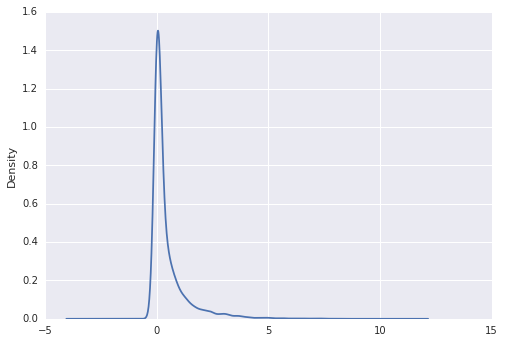

In [109]:
ser = df_features['Abs_Trade_Value_Diff']
ser.plot.kde()

In [59]:
print(df_features.columns)

Index(['TranID', 'Year', 'Team_1', 'Team_2', 'Trade_Value_Diff', 'WAR_Sum_1',
       'WAR_Sum_2', 'Num_Players_1', 'Num_Players_2', 'Ages_1', 'Ages_2',
       'Num_Player_Trades_1', 'Num_Player_Trades_2', 'Rank_1', 'Rank_2',
       'Num_Trades_Team_1', 'Num_Trades_Team_2', 'Salary_Diff',
       'Num_Player_Diff', 'Age_Diff', 'WAR_Diff'],
      dtype='object')


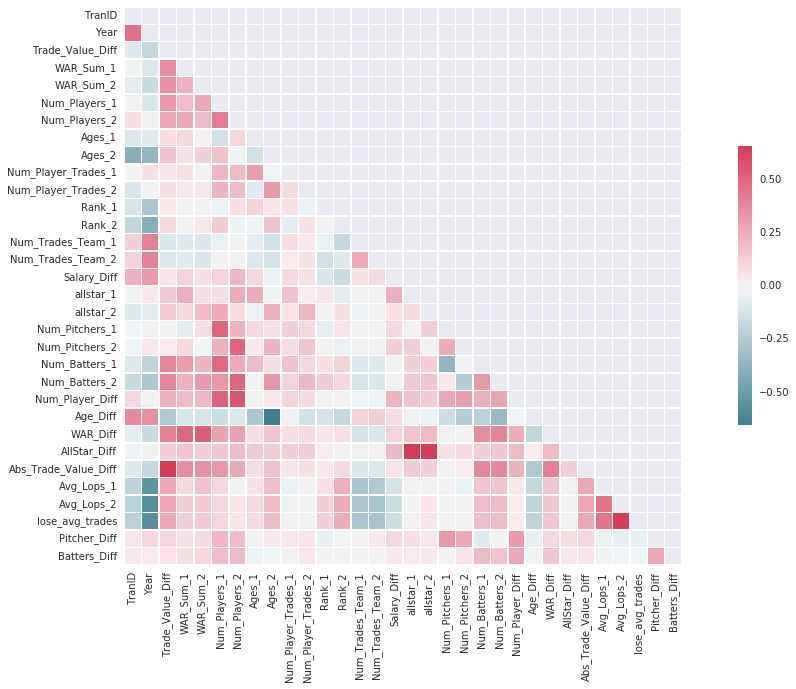

In [106]:
cols = df_features.columns
correlations = df_features[cols].corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 5, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask =mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=correlations.columns, yticklabels=correlations.columns,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [110]:
df_features = df_features.sample(frac=1)

In [100]:
inputV = df_features[["Pitcher_Diff","Batters_Diff"]]

In [101]:
clfList = [LinearRegression(),linear_model.Ridge(alpha = 0.5),Lasso(),DecisionTreeRegressor(max_depth=7),RandomForestRegressor(max_depth=10),neighbors.KNeighborsRegressor(n_neighbors=100)]

In [102]:
allRowsList = []
for idx,row in inputV.iterrows():
    currentRowList = row.values.tolist()
    allRowsList.append(currentRowList)

In [103]:
def calculate_error(actualValue, predictedValue):
    plt.xticks(range(-7,7,1))
    diff = (actualValue - predictedValue)
    ax = sns.distplot(diff, bins=50, label='Error in trade value diff')
    meanError = np.mean(diff)
    #print "Mean Error is", meanError
    stdError = np.std(diff)
    line1_string = 'Mean'
    line2_string = 'Std Dev'
    #ax.set_ylim((0,1))
    ax.set_xlim((-7,7))   
    ax.set_title('Probablity Distribution of Error')
    ax1 = ax.plot([meanError,meanError],[0,0.5])
    pos1 = [0,0.45]
    pos2 = [1,0.4]
    pos3 = [-1,0.4]
    ax.text(pos1[0], pos1[1], line1_string, size=9, color = 'b', ha="center", va="center")
    ax2 = ax.plot([stdError,stdError],[0,0.5], color='r')
    ax.text(pos2[0], pos2[1], line2_string, size=9, color = 'b', ha="center", va="center")
    ax3 = ax.plot([-stdError,-stdError],[0,0.5], color='r')
    ax.text(pos3[0], pos3[1], line2_string, size=9, color = 'b', ha="center", va="center")
    ax.set_xlabel('Error in trade value diff')
    ax.set_ylabel('Probability')
    plt.show()
    rms = sqrt(mean_squared_error(actualValue, predictedValue))
    print('Root mean square error:', rms)
    
    r2score = r2_score(actualValue, predictedValue)
    print('r2 score:', r2score)
    
    evs = explained_variance_score(actualValue, predictedValue)
    print('Explained variance score',evs)
    
    mae = mean_absolute_error(actualValue,predictedValue)
    print('Mean absolute error:',mae)


 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


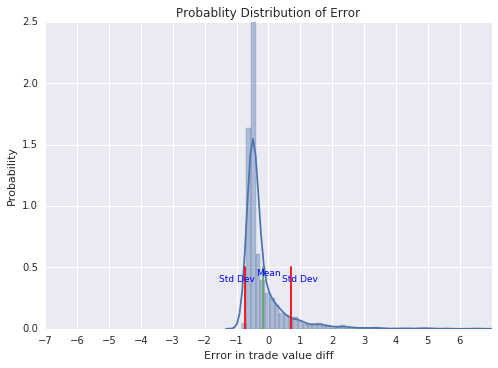

Root mean square error: 0.7414791041053781
r2 score: -0.0342901754127
Explained variance score 0.027224699005
Mean absolute error: 0.538487267117

 Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


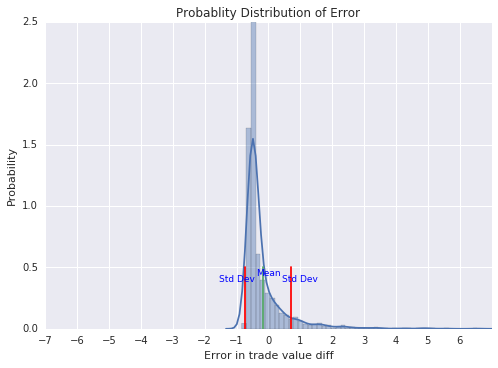

Root mean square error: 0.7414796856535388
r2 score: -0.0342917978179
Explained variance score 0.0272204098408
Mean absolute error: 0.538486572473

 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


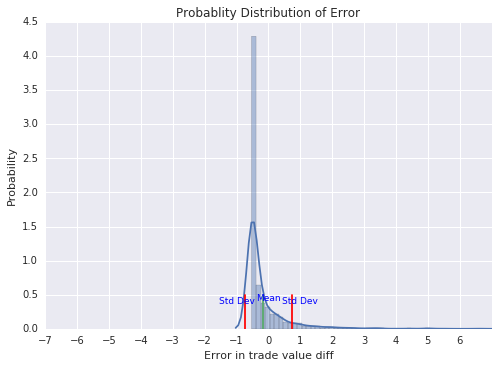

Root mean square error: 0.7486171042901563
r2 score: -0.0542996382905
Explained variance score 0.0
Mean absolute error: 0.540195048705

 DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')


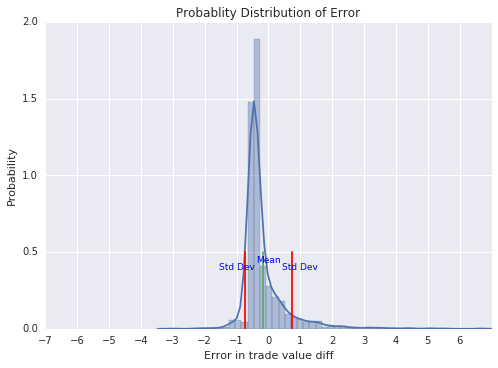

Root mean square error: 0.7490727567024611
r2 score: -0.055583446445
Explained variance score 0.00271713752512
Mean absolute error: 0.537429194008

 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


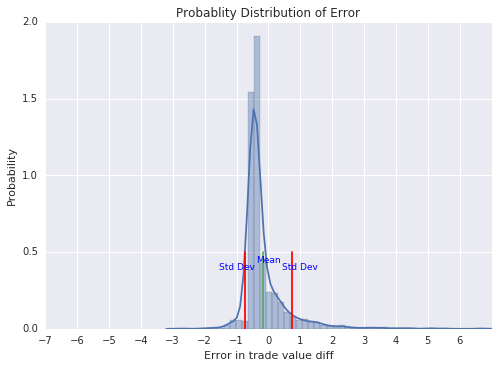

Root mean square error: 0.7471343170753983
r2 score: -0.0501272682025
Explained variance score 0.00476769738306
Mean absolute error: 0.534331954295

 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=100, p=2,
          weights='uniform')


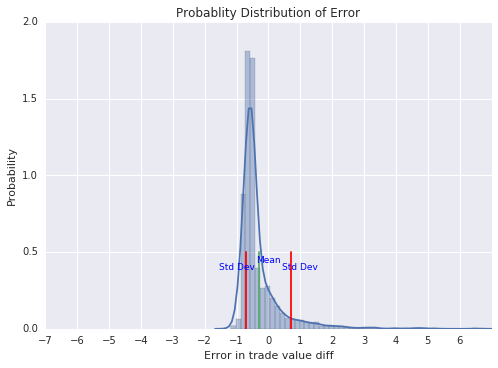

Root mean square error: 0.7762219671836771
r2 score: -0.13348668976
Explained variance score 0.0386841942079
Mean absolute error: 0.608699377685


In [104]:
from sklearn.metrics import f1_score
for i in clfList:
    clf = i.fit(allRowsList[:3963],df_features['Abs_Trade_Value_Diff'][:3963] )
    print("\n",i)
    predicted = clf.predict(allRowsList[3963:])
    calculate_error(df_features['Abs_Trade_Value_Diff'][3963:], predicted)

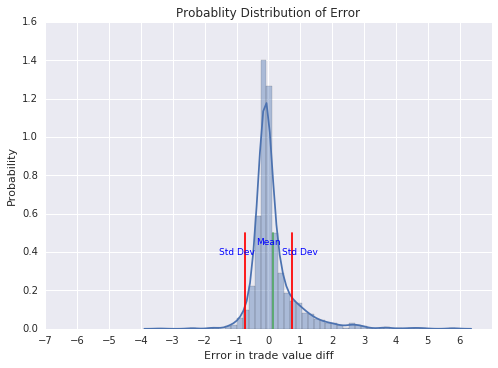

Root mean square error: 0.7441148295996464
r2 score: -0.0416563983919
Explained variance score -0.00481306106889
Mean absolute error: 0.415679931757


In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(allRowsList[:3963])
predict_ = poly.fit_transform(allRowsList[3963:])

clf = linear_model.LinearRegression()
clf.fit(X_, df_features['Trade_Value_Diff'][:3963])
pred = clf.predict(predict_)
calculate_error(df_features['Trade_Value_Diff'][3963:], pred)

In [ ]:
# prepare a uniform distribution to sample for the alpha parameter
param_grid = {'alpha': sp_rand()}
# create and fit a ridge regression model, testing random alpha values
model = linear_model.Ridge()
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
rsearch.fit(dataset.data, dataset.target)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

In [43]:
df_pref_features = df_features
inputV = df_pref_features[["Num_Player_Diff","Year","Age_Diff","WAR_Diff","Salary_Diff","AllStar_Diff"]]

In [44]:
len(df_pref_features)

5622

In [45]:
allRowsList = []
for idx,row in inputV.iterrows():
    currentRowList = row.values.tolist()
    allRowsList.append(currentRowList)

In [107]:
X_ = poly.fit_transform(allRowsList)
predict_ = poly.fit_transform(allRowsList)
pred = clf.predict(predict_)
print(len(pred))
df_pref_features['Predicted_Trade_Diff'] = pred

ValueError: query data dimension must match training data dimension

In [34]:
df_pref_features = df_pref_features.sort(columns='Predicted_Trade_Diff',ascending=False)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [35]:
pred_df = pd.DataFrame(columns = ['Rank','Date','Team1','Team2','Players Team1','Player Team2','Trade Value Diff'])
k = 0
for index,row in df_pref_features.iterrows():
    tranID = row['TranID']
    value = row['Predicted_Trade_Diff']
    tran = df_tran[df_tran['transaction-ID'] == tranID]
    teams = tran['from-team'].unique()
    t1 = teams[0]
    t2 = teams[1]
    p1List = []
    p2List = []
    for index,row in tran.iterrows():
        pl = df_master[df_master['retroID'] == row['player']]
        if row['from-team'] == t1:
            p1List.append(''.join(pl['nameFirst'].values +" "+ pl['nameLast'].values))
        else:
            p2List.append(''.join(pl['nameFirst'].values + " " + pl['nameLast'].values))
    p1str = ','.join(p1List)
    p2str = ','.join(p2List)
    date = tran['primary-date'].iloc[0]
    pred_df.loc[k] = [int(k+1),date,t1,t2,p1str,p2str,value]
    k += 1

In [142]:
pred_df.to_csv("Predicted_Ranks.csv")